# 30. CAM (Class Activation Mapping)

> **Ref - ** https://github.com/metalbubble/CAM/blob/master/pytorch_CAM.py

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import models
import torchvision.utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
from skimage.transform import resize

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 30.1 Prepare Data

In [3]:
# https://pytorch.org/docs/stable/torchvision/models.html
# https://github.com/pytorch/vision/tree/master/torchvision/models
# 미리 사용할 모델의 Input 파악 필수!

train_transform = transforms.Compose([
    transforms.Resize(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_data = dsets.ImageFolder('./data/dogcat/', train_transform)
train_loader = DataLoader(train_data, batch_size=1)

In [4]:
def imshow(img, title):
    img = torchvision.utils.make_grid(img, normalize=True)
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

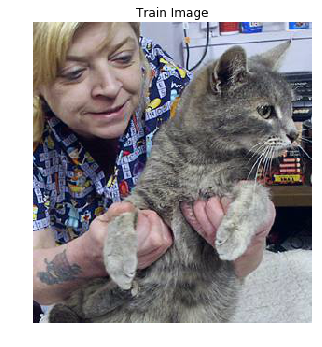

In [5]:
train_iter = iter(train_loader)
images, labels = train_iter.next()

imshow(images, "Train Image")

In [6]:
# 본래 GoogLeNet이 학습되었던 ImageNet 데이터의 Label 가져오기
labels = torch.load("./data/imagenet_label.pt")

## 30.2 Load Model

In [7]:
# GoogLeNet의 구조 확인
model = models.googlenet(pretrained=True)
model._modules.keys()

odict_keys(['conv1', 'maxpool1', 'conv2', 'conv3', 'maxpool2', 'inception3a', 'inception3b', 'maxpool3', 'inception4a', 'inception4b', 'inception4c', 'inception4d', 'inception4e', 'maxpool4', 'inception5a', 'inception5b', 'avgpool', 'dropout', 'fc'])

## 30.3 CAM

In [8]:
# 가장 마지막 Conv Layer의 Output 가져오기
last_conv_features = []
def hook_feature(module, input, output):
    last_conv_features.append(output.data.cpu().numpy())

# inception5b가 Output을 출력할 때마다 hook_feature을 호출
model._modules.get('inception5b').register_forward_hook(hook_feature)

In [9]:
# FC Layer의 weight을 가져오기
params = dict(model.fc.named_parameters())
weight_softmax = np.squeeze(params['weight'].cpu().data.numpy())

# 제대로 가져와짐을 확인가능
weight_softmax.shape

(1000, 1024)

In [10]:
# eval 모드에서 forward 진행
model.cuda().eval()
feature = model(images.cuda())

# Forward가 진행되었으므로 last_conv에 output이 저장됨
print("Shape of last conv feature:",last_conv_features[0].shape)

# 예측값 가져오기
_, pre = feature.max(dim=1)
print("Predicted:",labels[pre.item()])

Shape of last conv feature: (1, 1024, 10, 9)
Predicted: tabby, tabby cat


In [11]:
conv_feature = last_conv_features[0]
_, nc, h, w = conv_feature.shape

# CAM 구하기
cam = weight_softmax[pre].dot(conv_feature.reshape((nc, h*w)))
cam = cam.reshape(h, w)

# Min-Max Normalization
cam_img = (cam - np.min(cam)) / (np.max(cam)- np.min(cam))
cam_img = np.uint8(255 * cam_img)

# Resize
cam_img = resize(cam_img, (299, 299), mode='constant')

<Figure size 360x1080 with 0 Axes>

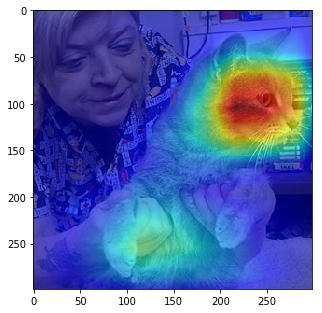

In [12]:
fig = plt.figure(figsize = (5, 15))

# 원래 이미지 그리기
img = torchvision.utils.make_grid(images, normalize=True)
npimg = img.numpy()
fig = plt.figure(figsize = (5, 15))
plt.imshow(np.transpose(npimg,(1,2,0)))

# CAM 레이어 추가하기
plt.imshow(cam_img, cmap='jet', alpha=0.6)
plt.show()